In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
plt.ion()

import sys
sys.path.append('../../')
import logomaker

In [2]:
# Set names of matrix files
ww_mat_file = 'matrices/ww_info_matrix.txt'
ss_mat_file = 'matrices/ss_prob_matrix.txt'
crp_mat_file = 'matrices/crp_energy_matrix.txt'
ars_mat_file = 'matrices/ars_weight_matrix.txt'
saliency_mat_file = 'matrices/saliency_matrix.txt'

Saliency matrix computed and saved to matrices/saliency_matrix.txt.


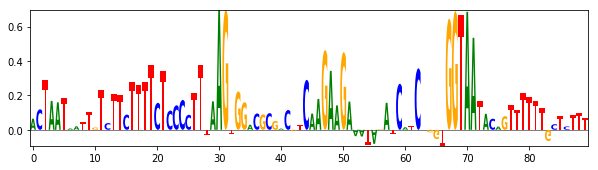

In [3]:
### Create saliency matrix

# load data
data_df = pd.read_excel('data/Janganathan2018_Fig1D.xlsx')

# get matrix
seq = ''.join(data_df['base'])
values = list(data_df['value'])
saliency_df = logomaker.saliency_to_matrix(seq,values)
saliency_df.head()

# show saliency matrix
logomaker.Logo(saliency_df)

# save file
saliency_df.to_csv(saliency_mat_file, sep='\t')
print('Saliency matrix computed and saved to %s.'%saliency_mat_file)

CRP energy matrix computed and saved to matrices/crp_energy_matrix.txt.


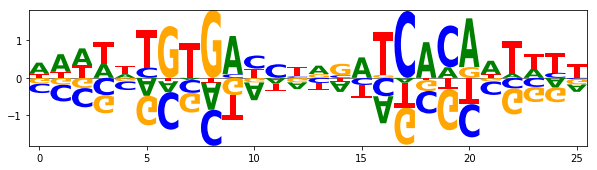

In [4]:
### Create CRP energy matrix

# load published energy matrix
energy_df = pd.read_csv('data/crp_tau_final_all.26.txt', delim_whitespace=True, index_col=0)
energy_df.columns = [c[-1] for c in energy_df.columns]
energy_df = logomaker.transform_matrix(energy_df, center_values=True)

# display energy matrix
logomaker.Logo(-energy_df)

# save file
energy_df.to_csv(crp_mat_file, sep='\t')
print('CRP energy matrix computed and saved to %s.'%crp_mat_file)

In [9]:
### Create ARS enrichment matrix

# read in fg sequences
fg_seqs_df = pd.read_csv('data/counts.exp3_lib_sat1_wt.txt', delim_whitespace=True)
fg_seqs_df.drop(0, axis=0, inplace=True)
fg_prob_df = logomaker.alignment_to_matrix(sequences=fg_seqs_df['ars'], counts=fg_seqs_df['ct'],
                                           to_type='probability')

# read in bg sequences
bg_seqs_df = pd.read_csv('data/counts.exp1_lib_ref.txt', delim_whitespace=True)
bg_seqs_df.drop(0, axis=0, inplace=True)
bg_prob_df = logomaker.alignment_to_matrix(sequences=bg_seqs_df['ars'], counts=bg_seqs_df['ct'],
                                           to_type='probability')

ARS enrichment matrix computed and saved to matrices/ars_weight_matrix.txt.


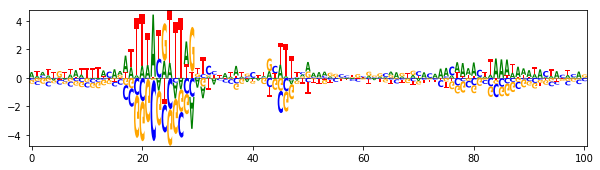

In [10]:
# compute enrichment matrix
enrich_df = np.log2(fg_prob_df/bg_prob_df)
enrich_df.loc[:,:] = np.fliplr(np.flipud(enrich_df.values))
enrich_df = enrich_df.loc[:100,:]
enrich_df = logomaker.transform_matrix(enrich_df, center_values=True)

# show enrichment matrix
logomaker.Logo(enrich_df)

# save file
enrich_df.to_csv(ars_mat_file, sep='\t')
print('ARS enrichment matrix computed and saved to %s.'%ars_mat_file)

WW domain matrix computed and saved to matrices/ww_info_matrix.txt.


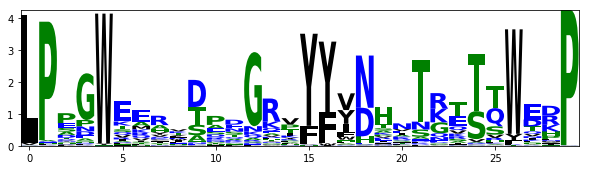

In [12]:
### Create WW domain information matrix

# load alignment of WW domain proteins
in_file = 'data/Pfam_wwdomain.fa'
with open(in_file, 'r') as f:
    text = f.read()
    lines = text.split('\n')
    seqs = [l.strip().upper() for l in lines if '#' not in l and '>' not in l and len(l.strip())>0]
    
# create counts matrix
counts_df = logomaker.alignment_to_matrix(seqs,characters_to_ignore='.-X')

# filter base on counts
num_seqs = counts_df.sum(axis=1)
pos_to_keep = num_seqs > len(seqs)/2
counts_df = counts_df[pos_to_keep]
counts_df.reset_index(drop=True, inplace=True)

# transform to information matrix
info_df = logomaker.transform_matrix(counts_df, from_type='counts', to_type='information')

# display information matrix
logomaker.Logo(info_df)

# save file
info_df.to_csv(ww_mat_file, sep='\t')
print('WW domain matrix computed and saved to %s.'%ww_mat_file)

splice site probability matrix computed and saved to matrices/ss_prob_matrix.txt.


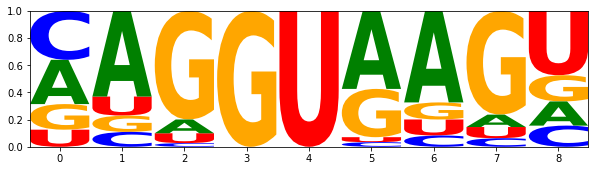

In [15]:
### Create splice site probability matrix

# load all splice sites
df = pd.read_csv('data/hg38_sss.txt', sep='\t', index_col=0)
df.head()

# get 5' splice sites
seqs = [s.replace('T','U') for s in df['ss5_seq'] if s[3:5] in {'GT','GU'}]

# compute probability matrix from sequence alignment
prob_df = logomaker.alignment_to_matrix(seqs, to_type='probability', pseudocount=0)

# display probability matrix
logo = logomaker.Logo(prob_df)

# save file
prob_df.to_csv(ss_mat_file, sep='\t')
print('splice site probability matrix computed and saved to %s.'%ss_mat_file)